# B02a: Circular Statistics for Phase Analysis (Part 1 of 2)

**Duration**: ~45 minutes

**Prerequisites**:
- B01: The Hilbert Transform (instantaneous phase extraction)
- Basic understanding of trigonometry (sin, cos, angles)

**Learning Objectives**:
1. Understand why phase is a circular (angular) variable
2. Master phase wrapping and unwrapping operations
3. Compute circular mean and variance correctly
4. Visualize phase distributions using polar plots
5. Build intuition for the resultant vector length (R)

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Phase as a Circular Variable](#section-2-phase-circular)
3. [Phase Wrapping and Unwrapping](#section-3-wrapping)
4. [Circular Mean](#section-4-circular-mean)
5. [Circular Variance and Concentration](#section-5-variance)
6. [Visualizing Phase Distributions](#section-6-visualization)
7. [Exercises](#section-7-exercises)
8. [Summary](#section-8-summary)
9. [External Resources](#section-9-resources)
10. [Discussion Questions](#section-10-discussion)

In [1]:
# ============================================================================
# B02a: Circular Statistics for Phase Analysis
# ============================================================================
# This notebook explores phase as a circular (angular) variable and builds
# the foundation for phase-based connectivity metrics like PLV.
#
# Prerequisites: B01 (The Hilbert Transform)
# ============================================================================

# =============================================================================
# Standard Library Imports
# =============================================================================
import numpy as np
from numpy.typing import NDArray
from typing import Optional, Tuple
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.stats import vonmises
import sys
from pathlib import Path

# =============================================================================
# Local Imports
# =============================================================================
src_path = Path.cwd().parents[2] / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from colors import COLORS
from filtering import bandpass_filter
from hilbert import compute_instantaneous_phase, compute_envelope

# =============================================================================
# Plot Configuration
# =============================================================================
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("B02a: Circular Statistics for Phase Analysis")
print("=" * 50)
print("Understanding phase as a circular variable")
print("Building tools for circular statistics")

B02a: Circular Statistics for Phase Analysis
Understanding phase as a circular variable
Building tools for circular statistics


---

<a id="section-1-introduction"></a>
## 1. Introduction

Phase synchronization is one of the most important mechanisms for neural communication. The **"Communication through Coherence"** hypothesis proposes that neurons communicate effectively when their oscillations are phase-aligned — allowing information to arrive at optimal moments in the receiving neuron's excitability cycle.

Many of the key connectivity metrics we'll study are built on phase relationships:
- **PLV** (Phase Locking Value): measures consistency of phase difference
- **PLI** (Phase Lag Index): considers the direction of phase lead/lag
- **wPLI** (weighted PLI): weights by the magnitude of phase difference

However, phase is fundamentally different from ordinary numbers — **it is circular**. An angle of 359° is very close to 1°, even though numerically they seem far apart. Standard statistics like mean and variance do not work correctly on circular data.

In this notebook, we build the mathematical tools for proper phase analysis:
- Phase wrapping and unwrapping
- Circular statistics (mean, variance, concentration)
- Visualization techniques for phase data

These tools form the foundation for all phase-based connectivity metrics.

---

<a id="section-2-phase-circular"></a>
## 2. Phase as a Circular Variable

Phase is an **angle**, typically represented in radians within the range [-π, π] or [0, 2π]. The key property that makes phase special is that it **wraps around**: a phase of π + 0.1 is actually very close to -π + 0.1, because they represent nearly the same position on the circle.

**Analogy: Clock times**

Consider the times 11:55 PM and 00:05 AM. Numerically, they seem very different (almost 12 hours apart), but in reality they are only 10 minutes apart. This is exactly how phase works!

**The averaging problem**

Linear arithmetic fails with circular data. Consider two phase values:
- φ₁ = -0.9π (just below -π, on the "negative" side)
- φ₂ = +0.9π (just above π, on the "positive" side)

The linear mean is (−0.9π + 0.9π) / 2 = 0. But this is completely wrong! Both phases are near π (or equivalently -π), so the mean should be approximately ±π.

We need **circular (directional) statistics** to handle phase correctly.

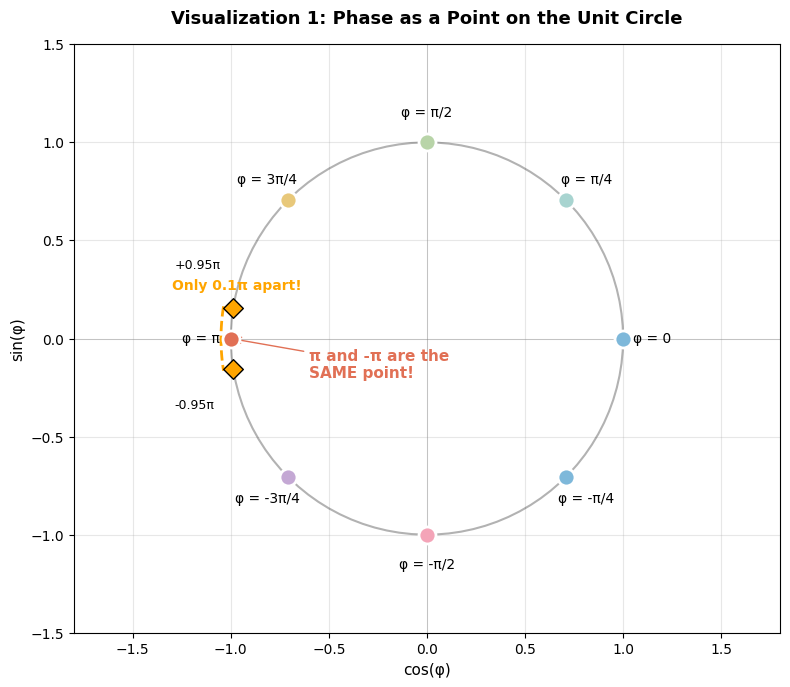

Key insight: Phase 'wraps around' — values near π and -π are very close!


In [2]:
# ============================================================================
# VISUALIZATION 1: Phase as a Point on the Unit Circle
# ============================================================================

# Create figure with unit circle
fig, ax = plt.subplots(figsize=(8, 8))

# Draw unit circle
theta_circle = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', linewidth=1.5, alpha=0.3)

# Draw reference lines
ax.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)

# Define some phase values to show
phase_values = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
phase_labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '-3π/4', '-π/2', '-π/4']
colors = [COLORS["signal_1"], COLORS["signal_6"], COLORS["signal_3"], COLORS["signal_4"], 
          COLORS["negative"], COLORS["signal_5"], COLORS["signal_2"], COLORS["signal_1"]]

# Plot each phase as a point on the circle
for phase, label, color in zip(phase_values, phase_labels, colors):
    x, y = np.cos(phase), np.sin(phase)
    ax.scatter(x, y, s=150, c=color, zorder=5, edgecolors='white', linewidths=2)
    # Add label with offset
    offset = 1.15
    ax.annotate(f'φ = {label}', xy=(x, y), xytext=(offset * x, offset * y),
                fontsize=10, ha='center', va='center')

# Highlight that π and -π are the same point!
ax.annotate('π and -π are the\nSAME point!', 
            xy=(-1, 0), xytext=(-0.6, -0.2),
            fontsize=11, color=COLORS["negative"], fontweight='bold',
            arrowprops=dict(arrowstyle='->', color=COLORS["negative"]))

# Draw a phase near the boundary to show closeness
phase_near_pi_pos = 0.95 * np.pi
phase_near_pi_neg = -0.95 * np.pi
x1, y1 = np.cos(phase_near_pi_pos), np.sin(phase_near_pi_pos)
x2, y2 = np.cos(phase_near_pi_neg), np.sin(phase_near_pi_neg)

ax.scatter([x1, x2], [y1, y2], s=100, c='orange', marker='D', zorder=6, edgecolors='black')
ax.annotate('+0.95π', xy=(x1, y1), xytext=(x1 - 0.3, y1 + 0.2), fontsize=9)
ax.annotate('-0.95π', xy=(x2, y2), xytext=(x2 - 0.3, y2 - 0.2), fontsize=9)

# Draw arc showing they are close
arc_theta = np.linspace(phase_near_pi_pos, 2*np.pi + phase_near_pi_neg, 20)
ax.plot(1.05 * np.cos(arc_theta), 1.05 * np.sin(arc_theta), 
        color='orange', linewidth=2, linestyle='--')
ax.annotate('Only 0.1π apart!', xy=(-1.1, 0), xytext=(-1.3, 0.25),
            fontsize=10, color='orange', fontweight='bold')

ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.set_title('Visualization 1: Phase as a Point on the Unit Circle', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('cos(φ)', fontsize=11)
ax.set_ylabel('sin(φ)', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: Phase 'wraps around' — values near π and -π are very close!")

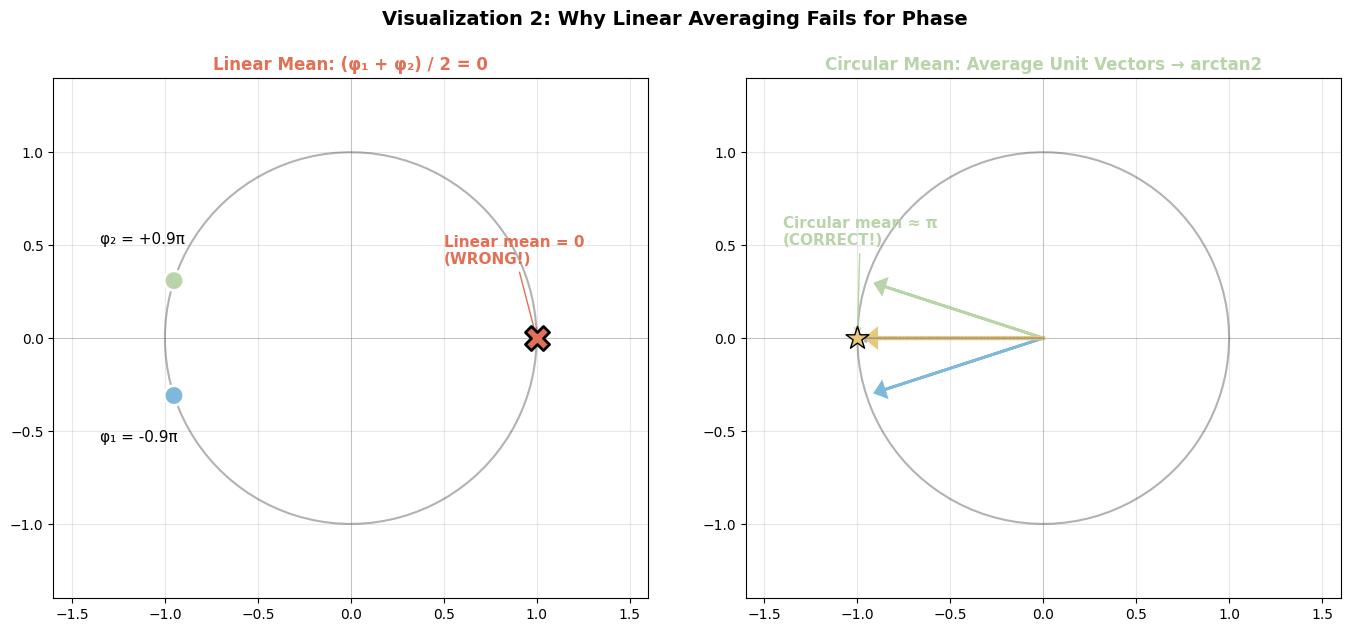

φ₁ = -0.90π, φ₂ = 0.90π
Linear mean: 0.00π (completely wrong!)
Circular mean: 1.00π (correct - both phases are near π)


In [3]:
# ============================================================================
# VISUALIZATION 2: The Circular Mean Problem
# ============================================================================

# Two phases that are both near π
phi1 = -0.9 * np.pi  # Just below π on negative side
phi2 = 0.9 * np.pi   # Just above π on positive side

# Linear mean (WRONG)
linear_mean = (phi1 + phi2) / 2  # = 0

# Circular mean (CORRECT)
# Convert to unit vectors, average, convert back
mean_x = (np.cos(phi1) + np.cos(phi2)) / 2
mean_y = (np.sin(phi1) + np.sin(phi2)) / 2
circular_mean = np.arctan2(mean_y, mean_x)  # ≈ π or -π

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- Left panel: Linear mean (wrong) ----
ax1 = axes[0]

# Draw unit circle
theta_circle = np.linspace(0, 2 * np.pi, 100)
ax1.plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', linewidth=1.5, alpha=0.3)
ax1.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
ax1.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)

# Plot the two phases
x1, y1 = np.cos(phi1), np.sin(phi1)
x2, y2 = np.cos(phi2), np.sin(phi2)
ax1.scatter([x1, x2], [y1, y2], s=200, c=[COLORS["signal_1"], COLORS["signal_3"]], 
            zorder=5, edgecolors='white', linewidths=2)
ax1.annotate(f'φ₁ = -0.9π', xy=(x1, y1), xytext=(x1 - 0.4, y1 - 0.25), fontsize=11)
ax1.annotate(f'φ₂ = +0.9π', xy=(x2, y2), xytext=(x2 - 0.4, y2 + 0.2), fontsize=11)

# Plot linear mean (WRONG) at phase = 0
x_lin = np.cos(linear_mean)
y_lin = np.sin(linear_mean)
ax1.scatter(x_lin, y_lin, s=300, c=COLORS["negative"], marker='X', zorder=6, 
            edgecolors='black', linewidths=2)
ax1.annotate(f'Linear mean = 0\n(WRONG!)', xy=(x_lin, y_lin), 
             xytext=(0.5, 0.4), fontsize=11, color=COLORS["negative"], fontweight='bold',
             arrowprops=dict(arrowstyle='->', color=COLORS["negative"]))

ax1.set_xlim(-1.6, 1.6)
ax1.set_ylim(-1.4, 1.4)
ax1.set_aspect('equal')
ax1.set_title('Linear Mean: (φ₁ + φ₂) / 2 = 0', fontsize=12, fontweight='bold', color=COLORS["negative"])
ax1.grid(True, alpha=0.3)

# ---- Right panel: Circular mean (correct) ----
ax2 = axes[1]

# Draw unit circle
ax2.plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', linewidth=1.5, alpha=0.3)
ax2.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
ax2.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)

# Plot the two phases as vectors
ax2.arrow(0, 0, 0.9*x1, 0.9*y1, head_width=0.08, head_length=0.05, 
          fc=COLORS["signal_1"], ec=COLORS["signal_1"], linewidth=2)
ax2.arrow(0, 0, 0.9*x2, 0.9*y2, head_width=0.08, head_length=0.05, 
          fc=COLORS["signal_3"], ec=COLORS["signal_3"], linewidth=2)

# Plot mean vector
mean_length = np.sqrt(mean_x**2 + mean_y**2)
ax2.arrow(0, 0, 0.9*mean_x/mean_length if mean_length > 0 else 0, 
          0.9*mean_y/mean_length if mean_length > 0 else 0, 
          head_width=0.08, head_length=0.05, 
          fc=COLORS["signal_4"], ec=COLORS["signal_4"], linewidth=3)

# Plot resultant (sum of vectors, not normalized)
ax2.arrow(0, 0, mean_x, mean_y, head_width=0.05, head_length=0.03,
          fc='gray', ec='gray', linewidth=1, alpha=0.5, linestyle='--')

# Plot circular mean point
x_circ = np.cos(circular_mean)
y_circ = np.sin(circular_mean)
ax2.scatter(x_circ, y_circ, s=300, c=COLORS["signal_4"], marker='*', zorder=6, 
            edgecolors='black', linewidths=1)

ax2.annotate(f'Circular mean ≈ π\n(CORRECT!)', xy=(x_circ, y_circ), 
             xytext=(-1.4, 0.5), fontsize=11, color=COLORS["signal_3"], fontweight='bold',
             arrowprops=dict(arrowstyle='->', color=COLORS["signal_3"]))

ax2.set_xlim(-1.6, 1.6)
ax2.set_ylim(-1.4, 1.4)
ax2.set_aspect('equal')
ax2.set_title('Circular Mean: Average Unit Vectors → arctan2', 
              fontsize=12, fontweight='bold', color=COLORS["signal_3"])
ax2.grid(True, alpha=0.3)

plt.suptitle('Visualization 2: Why Linear Averaging Fails for Phase', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"φ₁ = {phi1/np.pi:.2f}π, φ₂ = {phi2/np.pi:.2f}π")
print(f"Linear mean: {linear_mean/np.pi:.2f}π (completely wrong!)")
print(f"Circular mean: {circular_mean/np.pi:.2f}π (correct - both phases are near π)")

---

<a id="section-3-wrapping"></a>
## 3. Phase Wrapping and Unwrapping

When we extract phase from a signal, it is typically **wrapped** to the range [-π, π]. This means that as the phase naturally increases through a cycle, it suddenly "jumps" from π back to -π. This is purely a representation artifact — the phase is actually continuous.

**Phase wrapping**: The discontinuous jumps from π to -π (or vice versa)

**Phase unwrapping**: Removing these artificial jumps to create a continuous phase signal

Unwrapping is essential for:
- Computing **instantaneous frequency** (derivative of phase)
- Visualizing **phase evolution** over time
- Tracking **cumulative phase** across many cycles

The `np.unwrap()` function adds or subtracts 2π at each jump to create continuity.

**Caution**: Unwrapping can fail with very noisy or undersampled signals, as it may misinterpret noise as phase jumps.

In [4]:
# ============================================================================
# FUNCTIONS: Phase Wrapping and Unwrapping
# ============================================================================

def wrap_phase(phase: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Wrap phase values to the range [-π, π].
    
    Parameters
    ----------
    phase : NDArray[np.float64]
        Phase values in radians (can be any range).
        
    Returns
    -------
    NDArray[np.float64]
        Phase values wrapped to [-π, π].
        
    Examples
    --------
    >>> wrap_phase(np.array([3.5, -3.5, 7.0]))
    array([-2.78..., 2.78..., 0.71...])
    """
    return np.angle(np.exp(1j * phase))


def unwrap_phase(phase: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Unwrap phase to create a continuous signal.
    
    Removes discontinuities by adding ±2π at each jump.
    
    Parameters
    ----------
    phase : NDArray[np.float64]
        Wrapped phase values in radians.
        
    Returns
    -------
    NDArray[np.float64]
        Unwrapped (continuous) phase values.
        
    Notes
    -----
    Unwrapping may fail with very noisy or undersampled signals.
    """
    return np.unwrap(phase)


print("✓ wrap_phase() and unwrap_phase() functions defined")

✓ wrap_phase() and unwrap_phase() functions defined


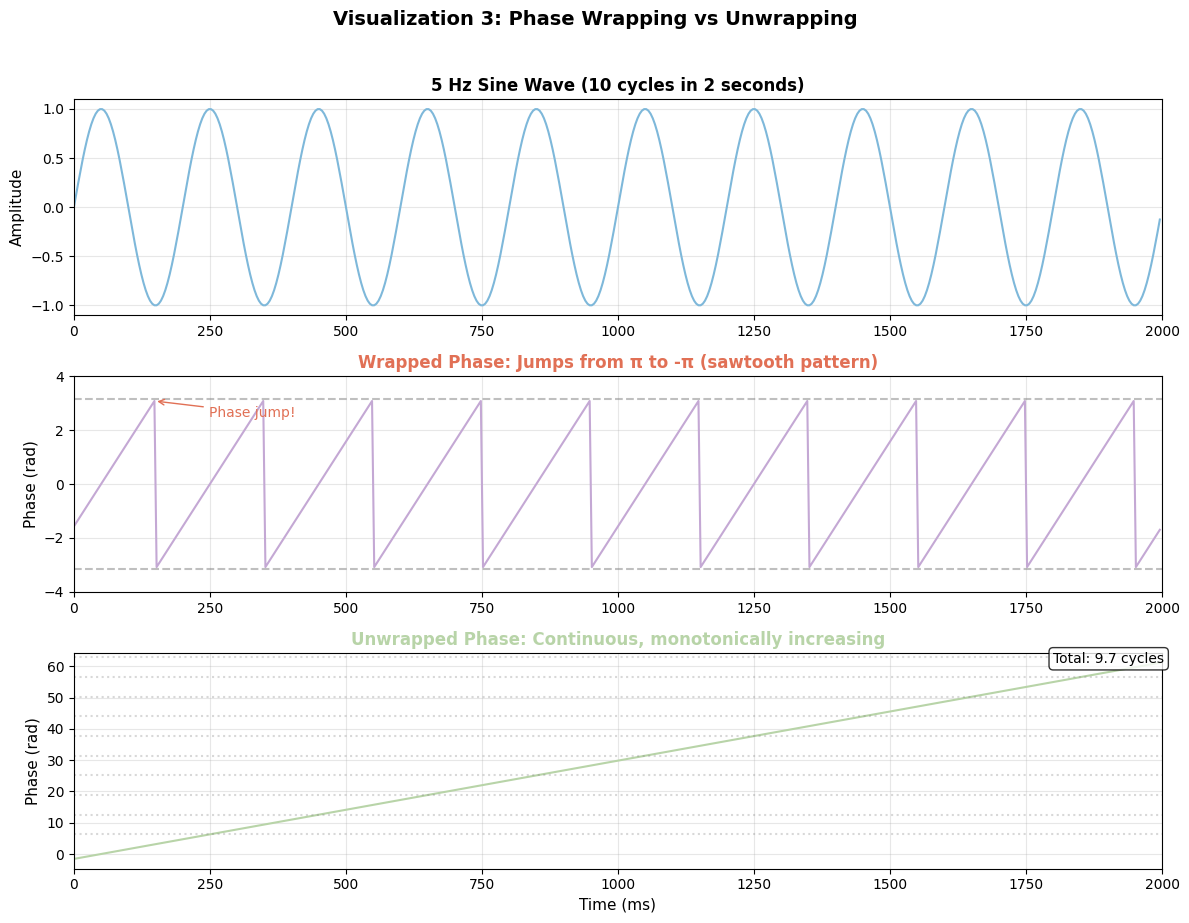

Signal: 5 Hz for 2.0 s = 10 complete cycles
Final unwrapped phase: 61.14 rad = 9.7 × 2π


In [5]:
# ============================================================================
# VISUALIZATION 3: Wrapped vs Unwrapped Phase
# ============================================================================

# Create a long sine wave (multiple cycles)
fs = 250
duration = 2.0  # 2 seconds
t = np.arange(0, duration, 1/fs)
freq = 5  # 5 Hz = 10 cycles in 2 seconds

# Generate signal and extract phase
signal = np.sin(2 * np.pi * freq * t)
analytic = hilbert(signal)
phase_wrapped = np.angle(analytic)
phase_unwrapped = np.unwrap(phase_wrapped)

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# Signal
axes[0].plot(t * 1000, signal, color=COLORS["signal_1"], linewidth=1.5)
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('5 Hz Sine Wave (10 cycles in 2 seconds)', fontsize=12, fontweight='bold')
axes[0].set_xlim(0, 2000)
axes[0].grid(True, alpha=0.3)

# Wrapped phase (sawtooth pattern)
axes[1].plot(t * 1000, phase_wrapped, color=COLORS["signal_5"], linewidth=1.5)
axes[1].axhline(y=np.pi, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(y=-np.pi, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Phase (rad)', fontsize=11)
axes[1].set_title('Wrapped Phase: Jumps from π to -π (sawtooth pattern)', 
                  fontsize=12, fontweight='bold', color=COLORS["negative"])
axes[1].set_xlim(0, 2000)
axes[1].set_ylim(-4, 4)
axes[1].grid(True, alpha=0.3)

# Annotate a jump
jump_idx = np.where(np.abs(np.diff(phase_wrapped)) > 5)[0][0]
axes[1].annotate('Phase jump!', xy=(t[jump_idx] * 1000, phase_wrapped[jump_idx]),
                 xytext=(t[jump_idx] * 1000 + 100, 2.5), fontsize=10, color=COLORS["negative"],
                 arrowprops=dict(arrowstyle='->', color=COLORS["negative"]))

# Unwrapped phase (continuous)
axes[2].plot(t * 1000, phase_unwrapped, color=COLORS["signal_3"], linewidth=1.5)
axes[2].set_xlabel('Time (ms)', fontsize=11)
axes[2].set_ylabel('Phase (rad)', fontsize=11)
axes[2].set_title('Unwrapped Phase: Continuous, monotonically increasing', 
                  fontsize=12, fontweight='bold', color=COLORS["signal_3"])
axes[2].set_xlim(0, 2000)
axes[2].grid(True, alpha=0.3)

# Add reference lines for multiples of 2π
for k in range(1, 11):
    axes[2].axhline(y=k * 2 * np.pi, color='gray', linestyle=':', alpha=0.3)

axes[2].annotate(f'Total: {phase_unwrapped[-1]/(2*np.pi):.1f} cycles', 
                 xy=(1800, phase_unwrapped[-1]), fontsize=10,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Visualization 3: Phase Wrapping vs Unwrapping', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Signal: {freq} Hz for {duration} s = {freq * duration:.0f} complete cycles")
print(f"Final unwrapped phase: {phase_unwrapped[-1]:.2f} rad = {phase_unwrapped[-1]/(2*np.pi):.1f} × 2π")

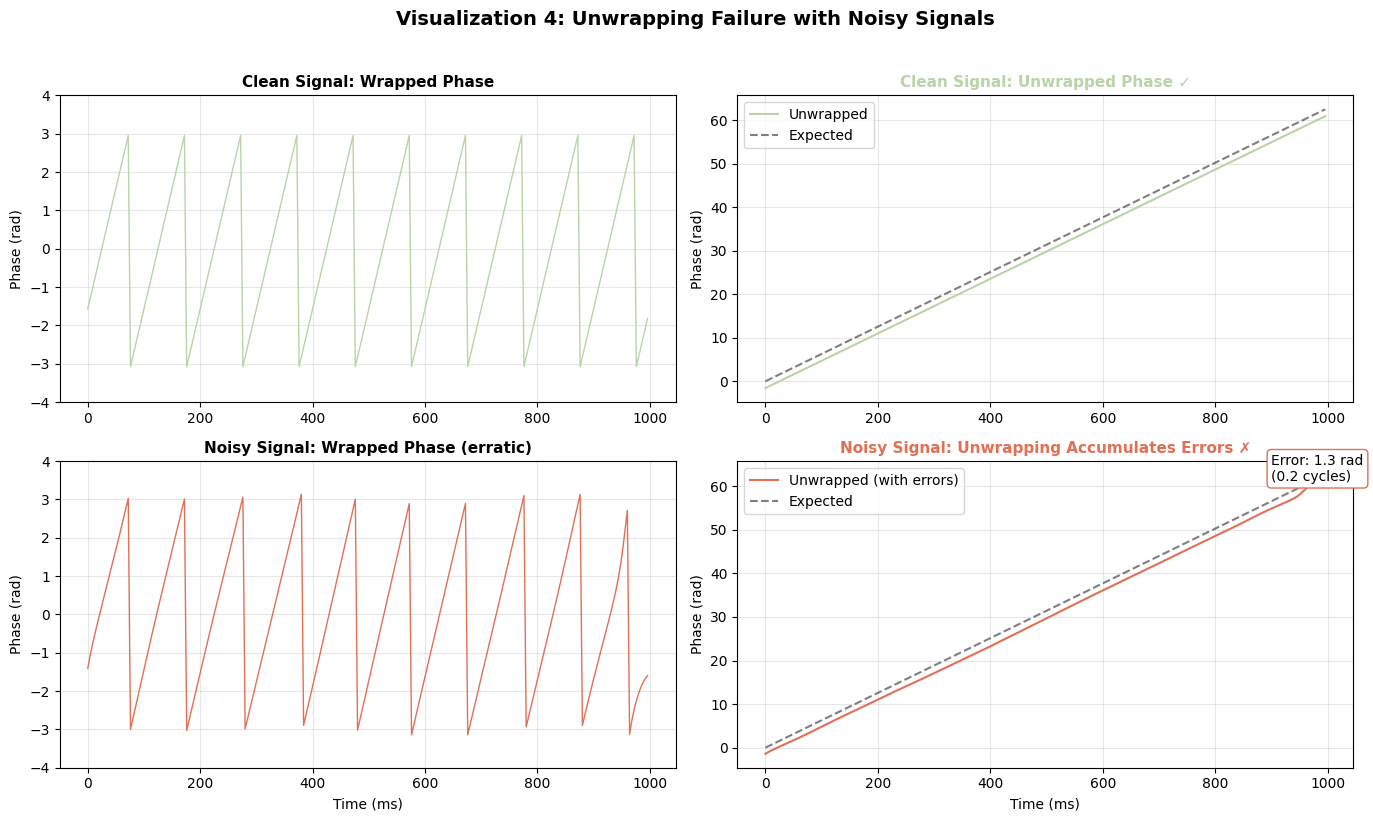

⚠️ Lesson: Unwrapping is reliable for clean signals, but accumulates errors with noise.
   For noisy EEG, prefer working with wrapped phase or use phase differences.


In [6]:
# ============================================================================
# VISUALIZATION 4: When Unwrapping Fails (Noisy Signal)
# ============================================================================

# Create a noisy narrowband signal
np.random.seed(42)
fs_noisy = 250
duration_noisy = 1.0
t_noisy = np.arange(0, duration_noisy, 1/fs_noisy)
freq_noisy = 10

# Clean signal
clean_signal = np.sin(2 * np.pi * freq_noisy * t_noisy)

# Add substantial noise
noise_level = 1.5  # High noise level
noisy_signal = clean_signal + noise_level * np.random.randn(len(t_noisy))

# Filter to narrow band (should help but noise still affects phase)
noisy_filtered = bandpass_filter(noisy_signal, 8, 12, fs_noisy)

# Extract phases
phase_clean = np.angle(hilbert(clean_signal))
phase_noisy = np.angle(hilbert(noisy_filtered))

# Unwrap both
phase_clean_unwrapped = np.unwrap(phase_clean)
phase_noisy_unwrapped = np.unwrap(phase_noisy)

# Expected unwrapped phase (theoretical)
expected_unwrapped = 2 * np.pi * freq_noisy * t_noisy

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Clean signal - wrapped
axes[0, 0].plot(t_noisy * 1000, phase_clean, color=COLORS["signal_3"], linewidth=1)
axes[0, 0].set_ylabel('Phase (rad)', fontsize=10)
axes[0, 0].set_title('Clean Signal: Wrapped Phase', fontsize=11, fontweight='bold')
axes[0, 0].set_ylim(-4, 4)
axes[0, 0].grid(True, alpha=0.3)

# Clean signal - unwrapped
axes[0, 1].plot(t_noisy * 1000, phase_clean_unwrapped, color=COLORS["signal_3"], linewidth=1.5, label='Unwrapped')
axes[0, 1].plot(t_noisy * 1000, expected_unwrapped, 'k--', alpha=0.5, label='Expected')
axes[0, 1].set_ylabel('Phase (rad)', fontsize=10)
axes[0, 1].set_title('Clean Signal: Unwrapped Phase ✓', fontsize=11, fontweight='bold', color=COLORS["signal_3"])
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# Noisy signal - wrapped
axes[1, 0].plot(t_noisy * 1000, phase_noisy, color=COLORS["negative"], linewidth=1)
axes[1, 0].set_xlabel('Time (ms)', fontsize=10)
axes[1, 0].set_ylabel('Phase (rad)', fontsize=10)
axes[1, 0].set_title('Noisy Signal: Wrapped Phase (erratic)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylim(-4, 4)
axes[1, 0].grid(True, alpha=0.3)

# Noisy signal - unwrapped (with errors)
axes[1, 1].plot(t_noisy * 1000, phase_noisy_unwrapped, color=COLORS["negative"], linewidth=1.5, label='Unwrapped (with errors)')
axes[1, 1].plot(t_noisy * 1000, expected_unwrapped, 'k--', alpha=0.5, label='Expected')
axes[1, 1].set_xlabel('Time (ms)', fontsize=10)
axes[1, 1].set_ylabel('Phase (rad)', fontsize=10)
axes[1, 1].set_title('Noisy Signal: Unwrapping Accumulates Errors ✗', 
                     fontsize=11, fontweight='bold', color=COLORS["negative"])
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

# Calculate error
final_error = np.abs(phase_noisy_unwrapped[-1] - expected_unwrapped[-1])
axes[1, 1].annotate(f'Error: {final_error:.1f} rad\n({final_error/(2*np.pi):.1f} cycles)', 
                    xy=(900, phase_noisy_unwrapped[-1]), fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor=COLORS["negative"]))

plt.suptitle('Visualization 4: Unwrapping Failure with Noisy Signals', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("⚠️ Lesson: Unwrapping is reliable for clean signals, but accumulates errors with noise.")
print("   For noisy EEG, prefer working with wrapped phase or use phase differences.")

---

<a id="section-4-circular-mean"></a>
## 4. Circular Mean

As we saw earlier, computing the average of phase values requires special treatment. The **circular mean** algorithm:

1. Convert each phase to a **unit vector**: $(cos(\phi), sin(\phi))$
2. **Average** the x and y components separately
3. Convert back to angle: $\bar{\phi} = atan2(\bar{y}, \bar{x})$

The result is the **preferred direction** of the phase distribution — the angle where phases tend to cluster.

**Important**: The *magnitude* of the resultant vector (before normalizing) tells us how concentrated the distribution is. This will be key for understanding PLV!

In [7]:
# ============================================================================
# FUNCTION: Circular Mean
# ============================================================================

def circular_mean(phases: NDArray[np.float64]) -> float:
    """
    Compute the circular (directional) mean of phase values.
    
    Uses the vector averaging method:
    1. Convert phases to unit vectors
    2. Average x and y components
    3. Return angle of resultant vector
    
    Parameters
    ----------
    phases : NDArray[np.float64]
        Array of phase values in radians.
        
    Returns
    -------
    float
        Circular mean in radians, range [-π, π].
        
    Notes
    -----
    The circular mean is undefined when R = 0 (uniform distribution).
    In this case, the function returns 0, but this should be interpreted
    with caution.
    
    Examples
    --------
    >>> circular_mean(np.array([0.1, 0.2, 0.15]))
    0.15  # Phases clustered around 0.15
    >>> circular_mean(np.array([-0.9*np.pi, 0.9*np.pi]))
    ≈ π  # Both near π, not 0!
    """
    mean_cos = np.mean(np.cos(phases))
    mean_sin = np.mean(np.sin(phases))
    return np.arctan2(mean_sin, mean_cos)


print("✓ circular_mean() function defined")

✓ circular_mean() function defined


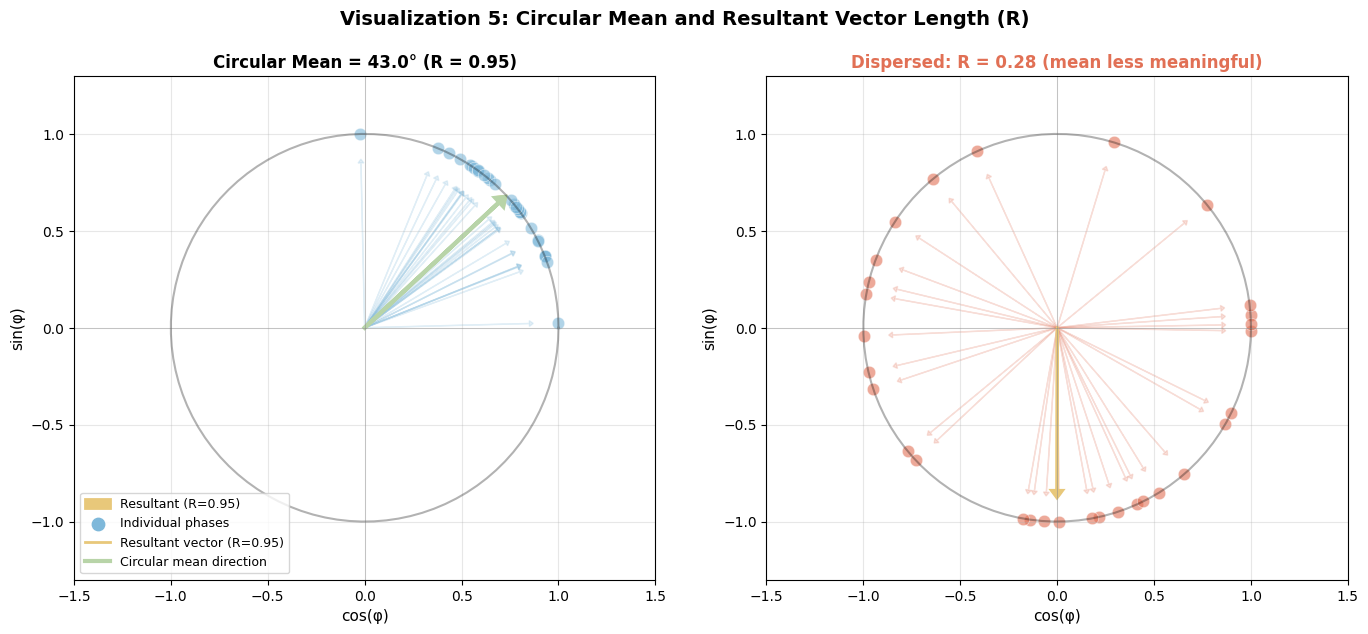

Concentrated distribution: R = 0.95 (high concentration, mean is meaningful)
Dispersed distribution: R = 0.28 (low concentration, mean is less meaningful)


In [8]:
# ============================================================================
# VISUALIZATION 5: Circular Mean Illustrated
# ============================================================================

# Generate phases clustered around π/4 with some spread
np.random.seed(42)
n_phases = 30
center_phase = np.pi / 4
spread = 0.3  # radians

# Use von Mises distribution (circular equivalent of Gaussian)
phases_clustered = vonmises.rvs(kappa=1/spread**2, loc=center_phase, size=n_phases)

# Wrap to [-π, π]
phases_clustered = wrap_phase(phases_clustered)

# Compute circular mean
circ_mean = circular_mean(phases_clustered)

# Compute resultant vector
mean_cos = np.mean(np.cos(phases_clustered))
mean_sin = np.mean(np.sin(phases_clustered))
R = np.sqrt(mean_cos**2 + mean_sin**2)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Unit circle with phases
ax1 = axes[0]
theta_circle = np.linspace(0, 2 * np.pi, 100)
ax1.plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', linewidth=1.5, alpha=0.3)
ax1.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
ax1.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)

# Plot individual phases as points
for phi in phases_clustered:
    ax1.scatter(np.cos(phi), np.sin(phi), s=80, c=COLORS["signal_1"], alpha=0.6, 
                edgecolors='white', linewidths=0.5)

# Plot individual unit vectors (faint)
for phi in phases_clustered:
    ax1.arrow(0, 0, 0.85*np.cos(phi), 0.85*np.sin(phi), 
              head_width=0.03, head_length=0.02, fc=COLORS["signal_1"], ec=COLORS["signal_1"], alpha=0.2)

# Plot resultant vector (sum)
ax1.arrow(0, 0, mean_cos, mean_sin, head_width=0.06, head_length=0.04,
          fc=COLORS["signal_4"], ec=COLORS["signal_4"], linewidth=2, label=f'Resultant (R={R:.2f})')

# Plot circular mean direction
ax1.arrow(0, 0, 0.95*np.cos(circ_mean), 0.95*np.sin(circ_mean), 
          head_width=0.06, head_length=0.04, fc=COLORS["signal_3"], ec=COLORS["signal_3"], linewidth=3)

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.3, 1.3)
ax1.set_aspect('equal')
ax1.set_title(f'Circular Mean = {np.rad2deg(circ_mean):.1f}° (R = {R:.2f})', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('cos(φ)', fontsize=11)
ax1.set_ylabel('sin(φ)', fontsize=11)
ax1.grid(True, alpha=0.3)

# Legend
ax1.scatter([], [], s=80, c=COLORS["signal_1"], label='Individual phases')
ax1.plot([], [], color=COLORS["signal_4"], linewidth=2, label=f'Resultant vector (R={R:.2f})')
ax1.plot([], [], color=COLORS["signal_3"], linewidth=3, label=f'Circular mean direction')
ax1.legend(loc='lower left', fontsize=9)

# Right: Dispersed distribution for comparison
ax2 = axes[1]

# Generate uniform-ish distribution
phases_dispersed = np.random.uniform(-np.pi, np.pi, n_phases)
circ_mean_disp = circular_mean(phases_dispersed)
mean_cos_disp = np.mean(np.cos(phases_dispersed))
mean_sin_disp = np.mean(np.sin(phases_dispersed))
R_disp = np.sqrt(mean_cos_disp**2 + mean_sin_disp**2)

ax2.plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', linewidth=1.5, alpha=0.3)
ax2.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
ax2.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)

for phi in phases_dispersed:
    ax2.scatter(np.cos(phi), np.sin(phi), s=80, c=COLORS["negative"], alpha=0.6,
                edgecolors='white', linewidths=0.5)
    ax2.arrow(0, 0, 0.85*np.cos(phi), 0.85*np.sin(phi),
              head_width=0.03, head_length=0.02, fc=COLORS["negative"], ec=COLORS["negative"], alpha=0.2)

# Resultant (very short for uniform)
ax2.arrow(0, 0, mean_cos_disp * 3, mean_sin_disp * 3, head_width=0.06, head_length=0.04,
          fc=COLORS["signal_4"], ec=COLORS["signal_4"], linewidth=2)

ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.3, 1.3)
ax2.set_aspect('equal')
ax2.set_title(f'Dispersed: R = {R_disp:.2f} (mean less meaningful)', 
              fontsize=12, fontweight='bold', color=COLORS["negative"])
ax2.set_xlabel('cos(φ)', fontsize=11)
ax2.set_ylabel('sin(φ)', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.suptitle('Visualization 5: Circular Mean and Resultant Vector Length (R)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Concentrated distribution: R = {R:.2f} (high concentration, mean is meaningful)")
print(f"Dispersed distribution: R = {R_disp:.2f} (low concentration, mean is less meaningful)")

---

<a id="section-5-variance"></a>
## 5. Circular Variance and Concentration

The **resultant vector length (R)** is the key measure of phase concentration:

$$R = \left| \frac{1}{N} \sum_{n=1}^{N} e^{i\phi_n} \right| = \sqrt{\bar{cos}^2 + \bar{sin}^2}$$

**Interpretation**:
- **R = 1**: All phases are identical (perfect concentration)
- **R = 0**: Phases are uniformly distributed (no preferred direction)
- **0 < R < 1**: Partial concentration

Related measures:
- **Circular variance**: $V = 1 - R$ (higher = more spread)
- **Circular standard deviation**: $\sigma = \sqrt{-2 \ln R}$

**Key insight**: R is exactly what **PLV measures**! PLV = R of the phase difference distribution between two signals.

In [9]:
# ============================================================================
# FUNCTIONS: Circular Variance and Related Measures
# ============================================================================

def resultant_vector_length(phases: NDArray[np.float64]) -> float:
    """
    Compute the resultant vector length (R) of a phase distribution.
    
    R measures the concentration of phases:
    - R = 1: all phases identical
    - R = 0: uniform distribution
    
    Parameters
    ----------
    phases : NDArray[np.float64]
        Array of phase values in radians.
        
    Returns
    -------
    float
        Resultant vector length R, range [0, 1].
        
    Notes
    -----
    This is equivalent to PLV when applied to phase differences!
    """
    return np.abs(np.mean(np.exp(1j * phases)))


def circular_variance(phases: NDArray[np.float64]) -> float:
    """
    Compute the circular variance of a phase distribution.
    
    Circular variance V = 1 - R, where R is the resultant vector length.
    
    Parameters
    ----------
    phases : NDArray[np.float64]
        Array of phase values in radians.
        
    Returns
    -------
    float
        Circular variance V, range [0, 1].
        Higher values indicate more dispersion.
    """
    return 1.0 - resultant_vector_length(phases)


def circular_std(phases: NDArray[np.float64]) -> float:
    """
    Compute the circular standard deviation of a phase distribution.
    
    Circular std = sqrt(-2 * ln(R)), where R is the resultant vector length.
    
    Parameters
    ----------
    phases : NDArray[np.float64]
        Array of phase values in radians.
        
    Returns
    -------
    float
        Circular standard deviation in radians.
        
    Notes
    -----
    Returns inf if R = 0 (uniform distribution).
    """
    R = resultant_vector_length(phases)
    if R == 0:
        return np.inf
    return np.sqrt(-2 * np.log(R))


print("✓ resultant_vector_length(), circular_variance(), circular_std() defined")

✓ resultant_vector_length(), circular_variance(), circular_std() defined


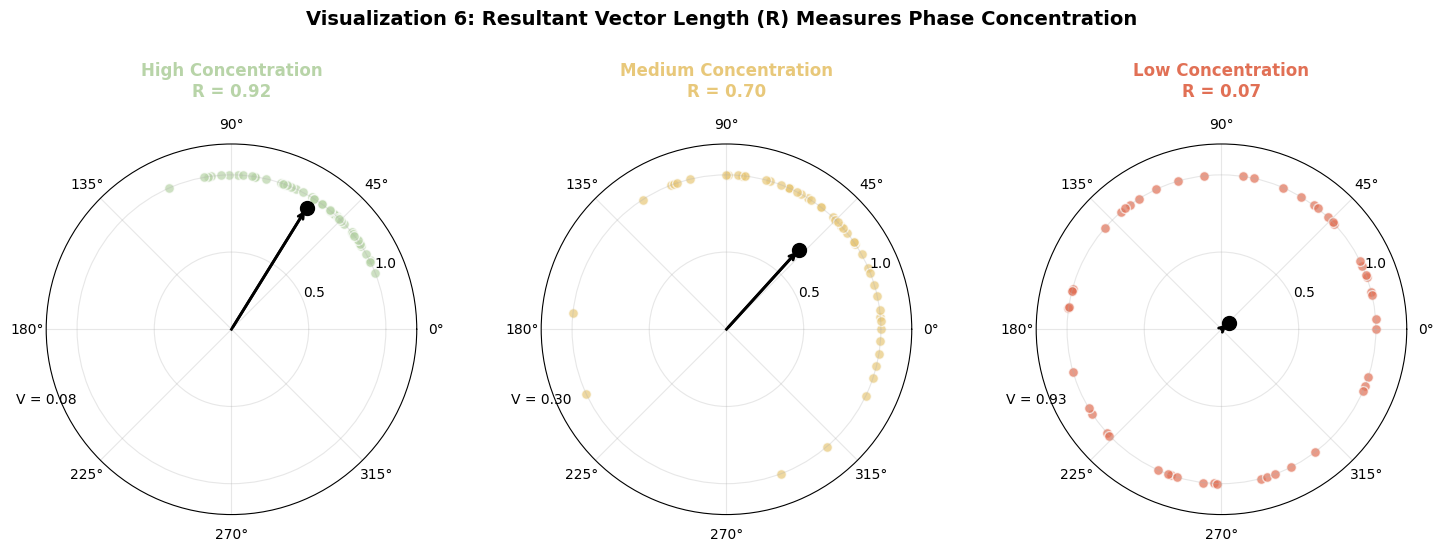

Interpretation of R:
  High concentration: R = 0.92 → Phases cluster tightly
  Medium concentration: R = 0.70 → Some clustering
  Low concentration: R = 0.07 → Nearly uniform (no preferred direction)

💡 When applied to phase differences, R becomes PLV!


In [10]:
# ============================================================================
# VISUALIZATION 6: Three Levels of Phase Concentration
# ============================================================================

# Create three distributions with different concentrations
np.random.seed(123)
n_samples = 50

# High concentration (κ = 10)
kappa_high = 10
phases_high = vonmises.rvs(kappa=kappa_high, loc=np.pi/3, size=n_samples)

# Medium concentration (κ = 2)
kappa_med = 2
phases_med = vonmises.rvs(kappa=kappa_med, loc=np.pi/3, size=n_samples)

# Low concentration (nearly uniform, κ = 0.1)
kappa_low = 0.1
phases_low = vonmises.rvs(kappa=kappa_low, loc=np.pi/3, size=n_samples)

# Compute R for each
R_high = resultant_vector_length(phases_high)
R_med = resultant_vector_length(phases_med)
R_low = resultant_vector_length(phases_low)

# Create figure with 3 polar plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='polar'))

distributions = [
    (phases_high, R_high, 'High Concentration', COLORS["signal_3"], kappa_high),
    (phases_med, R_med, 'Medium Concentration', COLORS["signal_4"], kappa_med),
    (phases_low, R_low, 'Low Concentration', COLORS["negative"], kappa_low)
]

for ax, (phases, R, title, color, kappa) in zip(axes, distributions):
    # Plot phases as points on unit circle
    ax.scatter(phases, np.ones_like(phases), s=50, c=color, alpha=0.7, edgecolors='white')
    
    # Plot mean direction
    mean_dir = circular_mean(phases)
    ax.annotate('', xy=(mean_dir, R), xytext=(mean_dir, 0),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    
    # Draw R as radial distance
    ax.plot([mean_dir, mean_dir], [0, R], 'k-', linewidth=2)
    ax.scatter(mean_dir, R, s=100, c='black', zorder=5)
    
    ax.set_ylim(0, 1.2)
    ax.set_rticks([0.5, 1.0])
    ax.set_title(f'{title}\nR = {R:.2f}', fontsize=12, fontweight='bold', 
                 color=color, pad=15)
    
    # Add variance info
    V = circular_variance(phases)
    ax.text(0, 0.3, f'V = {V:.2f}', ha='center', fontsize=10, 
            transform=ax.transAxes)

plt.suptitle('Visualization 6: Resultant Vector Length (R) Measures Phase Concentration', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("Interpretation of R:")
print(f"  High concentration: R = {R_high:.2f} → Phases cluster tightly")
print(f"  Medium concentration: R = {R_med:.2f} → Some clustering")
print(f"  Low concentration: R = {R_low:.2f} → Nearly uniform (no preferred direction)")
print("\n💡 When applied to phase differences, R becomes PLV!")

---

<a id="section-6-visualization"></a>
## 6. Visualizing Phase Distributions

Phase data requires specialized visualization techniques because of its circular nature:

1. **Linear histogram**: Simple but misleading at boundaries (phases near π and -π appear far apart)
2. **Polar histogram (rose plot)**: Natural circular representation
3. **Scatter on unit circle**: Shows individual phase values
4. **Mean vector overlay**: Shows preferred direction and concentration

Let's create reusable plotting functions and compare these approaches.

In [11]:
# ============================================================================
# FUNCTIONS: Phase Visualization
# ============================================================================

def plot_phase_polar_histogram(phases: NDArray[np.float64], 
                                n_bins: int = 36,
                                ax: Optional[plt.Axes] = None,
                                color: str = COLORS["signal_1"],
                                title: str = '') -> plt.Axes:
    """
    Create a polar histogram (rose plot) of phase values.
    
    Parameters
    ----------
    phases : NDArray[np.float64]
        Array of phase values in radians.
    n_bins : int, optional
        Number of angular bins (default: 36 = 10° bins).
    ax : plt.Axes, optional
        Matplotlib polar axes. If None, creates new figure.
    color : str, optional
        Color for the bars.
    title : str, optional
        Title for the plot.
        
    Returns
    -------
    plt.Axes
        The matplotlib axes object.
    """
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    
    # Create histogram
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    counts, edges = np.histogram(phases, bins=bins)
    
    # Plot as bars
    width = 2 * np.pi / n_bins
    centers = (edges[:-1] + edges[1:]) / 2
    ax.bar(centers, counts, width=width, color=color, alpha=0.7, edgecolor='white')
    
    ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
    return ax


def plot_phase_on_circle(phases: NDArray[np.float64],
                          ax: Optional[plt.Axes] = None,
                          show_mean: bool = True,
                          color: str = COLORS["signal_1"],
                          title: str = '') -> plt.Axes:
    """
    Plot phases as points on the unit circle.
    
    Parameters
    ----------
    phases : NDArray[np.float64]
        Array of phase values in radians.
    ax : plt.Axes, optional
        Matplotlib axes. If None, creates new figure.
    show_mean : bool, optional
        Whether to show the mean vector (default: True).
    color : str, optional
        Color for the points.
    title : str, optional
        Title for the plot.
        
    Returns
    -------
    plt.Axes
        The matplotlib axes object.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Draw unit circle
    theta = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=1, alpha=0.3)
    ax.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)
    
    # Plot phases as points
    x = np.cos(phases)
    y = np.sin(phases)
    ax.scatter(x, y, s=50, c=color, alpha=0.6, edgecolors='white', linewidths=0.5)
    
    if show_mean:
        mean_x = np.mean(np.cos(phases))
        mean_y = np.mean(np.sin(phases))
        R = np.sqrt(mean_x**2 + mean_y**2)
        ax.arrow(0, 0, mean_x * 0.95, mean_y * 0.95, 
                 head_width=0.05, head_length=0.03, fc='black', ec='black', linewidth=2)
        ax.text(0.05, -0.15, f'R = {R:.2f}', fontsize=10, transform=ax.transAxes)
    
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    return ax


print("✓ plot_phase_polar_histogram() and plot_phase_on_circle() defined")

✓ plot_phase_polar_histogram() and plot_phase_on_circle() defined


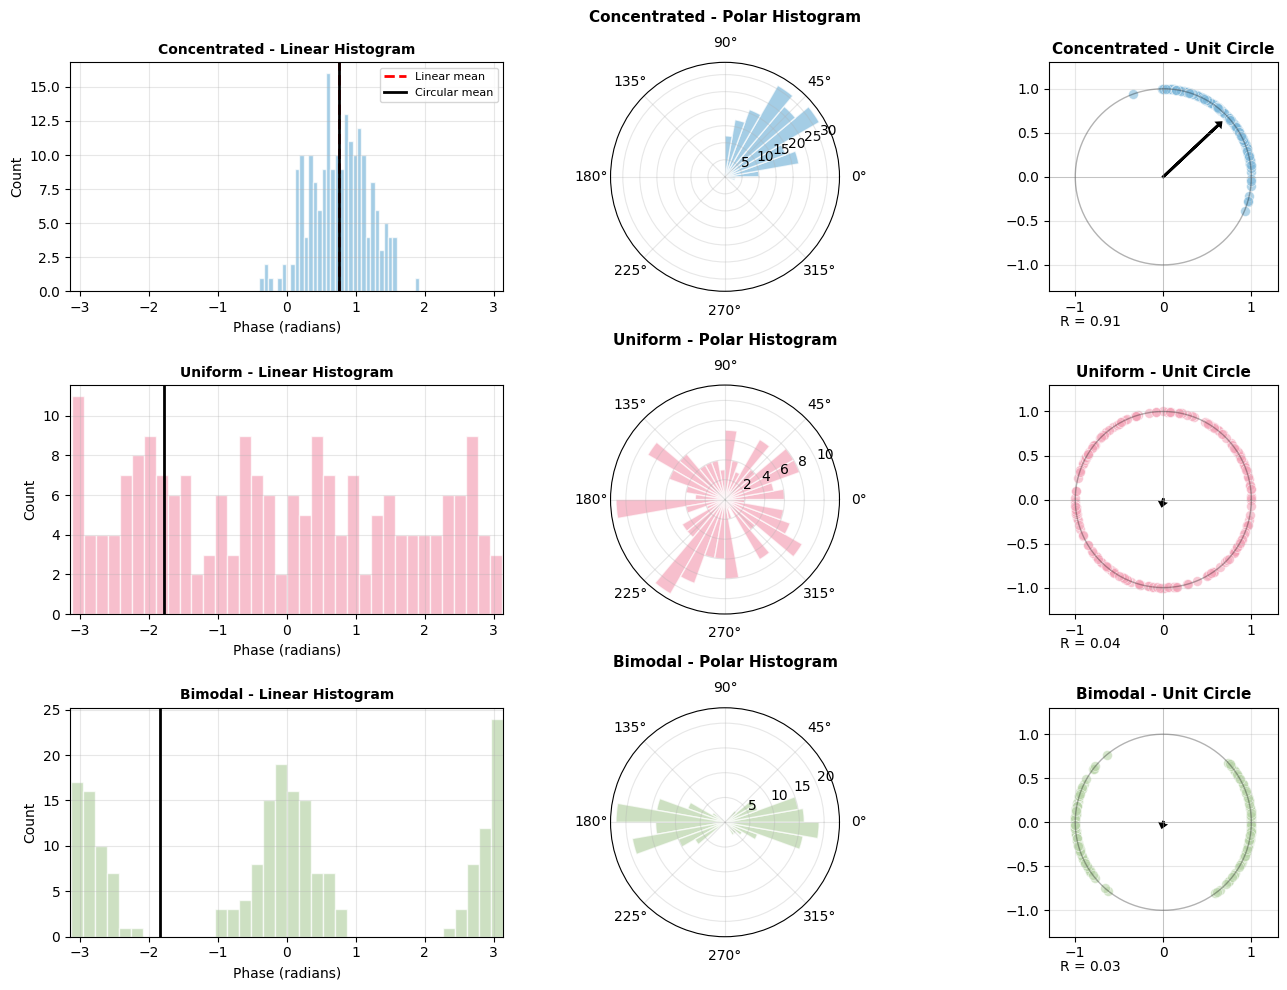


📊 Distribution Statistics:
------------------------------------------------------------

Concentrated:
  Circular Mean: 0.754 rad (43.2°)
  Resultant Vector Length (R): 0.913
  Circular Variance (V): 0.087

Uniform:
  Circular Mean: -1.783 rad (-102.2°)
  Resultant Vector Length (R): 0.043
  Circular Variance (V): 0.957

Bimodal:
  Circular Mean: -1.830 rad (-104.9°)
  Resultant Vector Length (R): 0.027
  Circular Variance (V): 0.973


In [12]:
# ============================================================================
# VISUALIZATION 7: Comparing Phase Visualization Methods
# ============================================================================

# Create phase distributions with different concentrations
np.random.seed(42)

# Concentrated distribution (von Mises with high kappa)
phases_concentrated = np.random.vonmises(mu=np.pi/4, kappa=5, size=200)

# Uniform distribution
phases_uniform = np.random.uniform(-np.pi, np.pi, size=200)

# Bimodal distribution
phases_bimodal = np.concatenate([
    np.random.vonmises(mu=0, kappa=8, size=100),
    np.random.vonmises(mu=np.pi, kappa=8, size=100)
])

fig = plt.figure(figsize=(14, 10))

# Row 1: Concentrated distribution
ax1 = fig.add_subplot(3, 3, 1)
ax1.hist(phases_concentrated, bins=36, color=COLORS["signal_1"], alpha=0.7, edgecolor='white')
ax1.axvline(np.mean(phases_concentrated), color='red', linestyle='--', linewidth=2, label='Linear mean')
ax1.axvline(circular_mean(phases_concentrated), color='black', linestyle='-', linewidth=2, label='Circular mean')
ax1.set_xlabel('Phase (radians)')
ax1.set_ylabel('Count')
ax1.set_title('Concentrated - Linear Histogram', fontsize=10, fontweight='bold')
ax1.legend(fontsize=8)
ax1.set_xlim(-np.pi, np.pi)

ax2 = fig.add_subplot(3, 3, 2, projection='polar')
plot_phase_polar_histogram(phases_concentrated, ax=ax2, color=COLORS["signal_1"], 
                           title='Concentrated - Polar Histogram')

ax3 = fig.add_subplot(3, 3, 3)
plot_phase_on_circle(phases_concentrated, ax=ax3, color=COLORS["signal_1"],
                     title='Concentrated - Unit Circle')

# Row 2: Uniform distribution
ax4 = fig.add_subplot(3, 3, 4)
ax4.hist(phases_uniform, bins=36, color=COLORS["signal_2"], alpha=0.7, edgecolor='white')
ax4.axvline(circular_mean(phases_uniform), color='black', linestyle='-', linewidth=2)
ax4.set_xlabel('Phase (radians)')
ax4.set_ylabel('Count')
ax4.set_title('Uniform - Linear Histogram', fontsize=10, fontweight='bold')
ax4.set_xlim(-np.pi, np.pi)

ax5 = fig.add_subplot(3, 3, 5, projection='polar')
plot_phase_polar_histogram(phases_uniform, ax=ax5, color=COLORS["signal_2"],
                           title='Uniform - Polar Histogram')

ax6 = fig.add_subplot(3, 3, 6)
plot_phase_on_circle(phases_uniform, ax=ax6, color=COLORS["signal_2"],
                     title='Uniform - Unit Circle')

# Row 3: Bimodal distribution
ax7 = fig.add_subplot(3, 3, 7)
ax7.hist(phases_bimodal, bins=36, color=COLORS["signal_3"], alpha=0.7, edgecolor='white')
ax7.axvline(circular_mean(phases_bimodal), color='black', linestyle='-', linewidth=2)
ax7.set_xlabel('Phase (radians)')
ax7.set_ylabel('Count')
ax7.set_title('Bimodal - Linear Histogram', fontsize=10, fontweight='bold')
ax7.set_xlim(-np.pi, np.pi)

ax8 = fig.add_subplot(3, 3, 8, projection='polar')
plot_phase_polar_histogram(phases_bimodal, ax=ax8, color=COLORS["signal_3"],
                           title='Bimodal - Polar Histogram')

ax9 = fig.add_subplot(3, 3, 9)
plot_phase_on_circle(phases_bimodal, ax=ax9, color=COLORS["signal_3"],
                     title='Bimodal - Unit Circle')

plt.tight_layout()
plt.show()

# Print statistics for each distribution
print("\n📊 Distribution Statistics:")
print("-" * 60)
for name, phases, color in [("Concentrated", phases_concentrated, "signal_1"),
                            ("Uniform", phases_uniform, "signal_2"),
                            ("Bimodal", phases_bimodal, "signal_3")]:
    R = resultant_vector_length(phases)
    V = circular_variance(phases)
    mean_phase = circular_mean(phases)
    print(f"\n{name}:")
    print(f"  Circular Mean: {mean_phase:.3f} rad ({np.degrees(mean_phase):.1f}°)")
    print(f"  Resultant Vector Length (R): {R:.3f}")
    print(f"  Circular Variance (V): {V:.3f}")

---

<a id="section-7-exercises"></a>
## 7. Exercises

### 🎯 Exercise 1: Linear vs Circular Mean

**Task:** Demonstrate why circular statistics are essential for phase data.

1. Create two phase values at -170° and +170° (convert to radians)
2. Calculate both the linear (arithmetic) mean and circular mean
3. Visualize the two phases and both means on a unit circle
4. Explain why the results differ

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Create phase values at -170° and +170°
phase1 = np.radians(-170)  # -2.97 rad
phase2 = np.radians(170)   # 2.97 rad
phases = np.array([phase1, phase2])

# Calculate means
linear_mean = np.mean(phases)
circ_mean = circular_mean(phases)

print("Two phases: -170° and +170°")
print(f"Linear (arithmetic) mean: {np.degrees(linear_mean):.1f}°")
print(f"Circular mean: {np.degrees(circ_mean):.1f}°")

# Visualize
fig, ax = plt.subplots(figsize=(8, 8))

# Draw unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=1, alpha=0.3)
ax.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)

# Plot phases
for i, (ph, label) in enumerate([(phase1, '-170°'), (phase2, '+170°')]):
    ax.scatter(np.cos(ph), np.sin(ph), s=150, c=COLORS["signal_1"], 
               edgecolors='black', linewidths=2, zorder=5)
    ax.annotate(label, (np.cos(ph)*1.15, np.sin(ph)*1.15), fontsize=12, ha='center')

# Plot linear mean (WRONG)
ax.arrow(0, 0, np.cos(linear_mean)*0.85, np.sin(linear_mean)*0.85,
         head_width=0.05, head_length=0.03, fc='red', ec='red', linewidth=2)
ax.annotate(f'Linear: {np.degrees(linear_mean):.1f}°', 
            (np.cos(linear_mean)*1.1, np.sin(linear_mean)*1.1),
            fontsize=10, color='red', fontweight='bold')

# Plot circular mean (CORRECT)
ax.arrow(0, 0, np.cos(circ_mean)*0.85, np.sin(circ_mean)*0.85,
         head_width=0.05, head_length=0.03, fc='green', ec='green', linewidth=2)
ax.annotate(f'Circular: {np.degrees(circ_mean):.1f}°', 
            (np.cos(circ_mean)*1.1, np.sin(circ_mean)*1.1),
            fontsize=10, color='green', fontweight='bold')

ax.set_xlim(-1.4, 1.4)
ax.set_ylim(-1.4, 1.4)
ax.set_aspect('equal')
ax.set_title('Linear vs Circular Mean\n-170° and +170° are close on the circle!', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.show()

# Explanation
print("\n📝 Explanation:")
print("The linear mean gives 0°, which is on the OPPOSITE side of the circle!")
print("The circular mean correctly identifies that -170° and +170° are close")
print("and their average direction is around ±180° (the 6 o'clock position).")
```

</details>

---

### 🎯 Exercise 2: Concentration and Resultant Vector Length

**Task:** Explore how phase concentration affects circular statistics.

1. Generate three phase distributions using von Mises distribution:
   - Low concentration: κ = 0.5
   - Medium concentration: κ = 2
   - High concentration: κ = 10
2. Calculate R (resultant vector length) and V (circular variance) for each
3. Create a visualization showing all three distributions
4. What is the relationship between κ and R?

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Generate distributions with different concentrations
np.random.seed(42)
n_samples = 500
mean_phase = np.pi/3  # 60°

kappas = [0.5, 2, 10]
labels = ['Low (κ=0.5)', 'Medium (κ=2)', 'High (κ=10)']
colors_list = [COLORS["signal_1"], COLORS["signal_2"], COLORS["signal_3"]]

fig, axes = plt.subplots(1, 3, figsize=(14, 5), subplot_kw=dict(projection='polar'))

print("📊 Concentration vs Circular Statistics:")
print("-" * 50)

for ax, kappa, label, color in zip(axes, kappas, labels, colors_list):
    # Generate phases
    phases = np.random.vonmises(mu=mean_phase, kappa=kappa, size=n_samples)
    
    # Calculate statistics
    R = resultant_vector_length(phases)
    V = circular_variance(phases)
    cm = circular_mean(phases)
    
    # Plot polar histogram
    plot_phase_polar_histogram(phases, ax=ax, color=color, title=f'{label}\nR={R:.3f}, V={V:.3f}')
    
    # Add mean direction arrow
    ax.annotate('', xy=(cm, R * ax.get_ylim()[1]), xytext=(cm, 0),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    
    print(f"\n{label}:")
    print(f"  Resultant Vector Length (R): {R:.3f}")
    print(f"  Circular Variance (V): {V:.3f}")

plt.tight_layout()
plt.show()

# Explanation
print("\n📝 Relationship between κ and R:")
print("• Higher κ → more concentrated distribution → higher R")
print("• κ ≈ 0 gives uniform distribution (R ≈ 0)")
print("• As κ → ∞, distribution becomes a point mass (R → 1)")
print("\nThis is why R is used as a synchronization measure:")
print("High R means phases are tightly clustered (synchronized)")
```

</details>

---

<a id="section-8-summary"></a>
## 8. Summary

### Key Concepts

| Concept | Description | Key Formula/Property |
|---------|-------------|---------------------|
| **Phase as circular variable** | Phase angles wrap around at ±π, representing points on unit circle | Range: [-π, π] or [0, 2π] |
| **Phase wrapping** | Constraining angles to standard interval | `np.angle(np.exp(1j * phase))` |
| **Phase unwrapping** | Removing artificial discontinuities | `np.unwrap(phase)` |
| **Circular mean** | Average direction using vector representation | $\bar{\theta} = \arctan2(\sum \sin\theta, \sum \cos\theta)$ |
| **Resultant vector length (R)** | Measure of concentration, 0 (uniform) to 1 (identical) | $R = \|\frac{1}{n}\sum e^{i\theta}\|$ |
| **Circular variance (V)** | Dispersion measure, 0 (concentrated) to 1 (uniform) | $V = 1 - R$ |
| **Circular std (s)** | Analog of standard deviation | $s = \sqrt{-2\ln(R)}$ |

### Functions Reference

```python
# Phase wrapping and unwrapping
wrapped = wrap_phase(phase)      # Wrap to [-π, π]
unwrapped = unwrap_phase(phase)  # Remove discontinuities

# Circular statistics
mean_angle = circular_mean(phases)           # Average direction
R = resultant_vector_length(phases)          # Concentration (0 to 1)
V = circular_variance(phases)                # Dispersion (0 to 1)
s = circular_std(phases)                     # Standard deviation

# Visualization
plot_phase_polar_histogram(phases, n_bins, ax, color, title)
plot_phase_on_circle(phases, ax, show_mean, color, title)
```

### Why This Matters for Connectivity

| Circular Statistic | Connectivity Application |
|--------------------|-------------------------|
| **Circular mean** | Average phase relationship between signals |
| **Resultant vector length (R)** | Foundation of PLV (Phase Locking Value) |
| **Circular variance** | Measure of synchronization stability |
| **Phase visualization** | Understanding inter-brain coupling patterns |

### ⚠️ Common Pitfalls

1. **Using arithmetic mean on phases** → Can give completely wrong results
2. **Forgetting to wrap after operations** → Angles outside [-π, π]
3. **Interpreting R without context** → R depends on sample size
4. **Ignoring bimodal distributions** → Circular mean can be misleading

---

<a id="section-9-external-resources"></a>
## 9. External Resources

### 📚 Scientific References

- **Fisher, N.I. (1993)** - *Statistical Analysis of Circular Data* - The definitive textbook on circular statistics
- **Mardia, K.V. & Jupp, P.E. (2000)** - *Directional Statistics* - Comprehensive mathematical treatment
- **Berens, P. (2009)** - *CircStat: A MATLAB Toolbox for Circular Statistics* - Practical implementation guide

### 🎧 NotebookLM Resources

*Resources will be added after NotebookLM content creation:*

- [📺 Video Overview](URL) - Video overview of circular statistics concepts
- [📝 Quiz](URL) - Test your understanding of circular statistics
- [🗂️ Flashcards](URL) - Review key concepts

### 🔗 Online Resources

- [Wikipedia: Directional Statistics](https://en.wikipedia.org/wiki/Directional_statistics)
- [CircStat Python Package](https://github.com/circstat/pycircstat)
- [Scipy.stats.circmean documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.circmean.html)

---

<a id="section-10-discussion"></a>
## 10. Discussion Questions

1. **Why can't we use standard statistics?**  
   Explain to a colleague why we can't simply use `np.mean()` and `np.std()` for phase data. Give a concrete example where linear statistics would fail.

2. **R as a synchronization measure**  
   The resultant vector length R ranges from 0 to 1. In hyperscanning, what would R = 0.1 vs R = 0.9 mean for two participants' brain signals?

3. **Bimodal phase distributions**  
   If two brain regions show a bimodal phase distribution (peaks at 0° and 180°), what might this tell us about their functional relationship? Is the circular mean meaningful in this case?

4. **Sample size considerations**  
   A researcher finds R = 0.95 with 5 phase samples and R = 0.3 with 10,000 samples. Which result is more indicative of true synchronization? Why?

5. **From circular statistics to PLV**  
   Based on what you learned about R (resultant vector length), how would you design a measure to quantify phase synchronization between two signals? What would you call the numerator and denominator?

---

**Next notebook:** [B02b: Phase Relationships](B02b_phase_relationships.ipynb) - Apply circular statistics to compare phases between two signals